In [1]:
import pandas as pd
import pickle
import ledapy
import tqdm
import neurokit2 as nk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cgm_data = pd.read_pickle('../../dataset/processed/c1s01/1000.pkl')

cgm_idx = cgm_data['Index']
cgm_timestamp = cgm_data['Timestamp']
cgm_glucose = cgm_data['glucose']

## ECG Data

In [3]:
ecg_data = cgm_data['zephyr']['ECG']
summary_data = cgm_data['zephyr']['Summary']

In [4]:
fs = 250
ecg_clean = nk.ecg_clean(ecg_data['EcgWaveform'], sampling_rate=fs)
_, rpeaks = nk.ecg_peaks(ecg_clean, sampling_rate=fs, correct_artifacts=True)
r_peaks = np.unique(rpeaks['ECG_R_Peaks'])

window_size = 3 * fs

extracted_ecg = []
for peak in tqdm.tqdm(r_peaks):
    start_idx = peak - window_size//2
    end_idx = start_idx + window_size
    try:
        start_t = ecg_data['Time'][start_idx]
        end_t = ecg_data['Time'][end_idx]
        beat_ecg = ecg_clean[start_idx:end_idx]

        if beat_ecg.shape[0] == 0:
            continue
        
        summary_window = (summary_data['Time'] >= start_t) & (summary_data['Time'] < end_t)
        avg_HRConfidence = summary_data["HRConfidence"][summary_window].mean()
        avg_ECGNoise = summary_data["ECGNoise"][summary_window].mean()

        extracted_ecg.append({
            'ecg': beat_ecg,
            'start_t': start_t,
            'end_t': end_t,
            'glucose': cgm_glucose,
            'CGM_idx': cgm_idx,
            'Timestamp': cgm_timestamp,
            'HRConfidence': avg_HRConfidence,
            'ECGNoise': avg_ECGNoise
        })
    except:
        pass

extracted_ecg = pd.DataFrame(extracted_ecg)


100%|██████████| 332/332 [00:00<00:00, 47098.32it/s]


In [5]:
clean_extracted_ecg = extracted_ecg[extracted_ecg['HRConfidence'] >= 100 & (extracted_ecg['ECGNoise'] <= 0.001)]
clean_extracted_ecg = clean_extracted_ecg.sort_values('start_t')
print(clean_extracted_ecg)

                                                   ecg  \
0    [-6.004427522470994, -6.789295981312635, -7.33...   
1    [-8.92889156703776, -8.854039512791505, -8.779...   
2    [-9.856148505944251, -9.745212248405947, -9.71...   
3    [-9.018449096629421, -9.087183076026966, -9.07...   
4    [-8.591190664719068, -8.43446947868134, -8.277...   
..                                                 ...   
324  [-20.439430290667506, -20.55611322578886, -20....   
325  [-22.06621508210509, -22.18197735553387, -22.3...   
326  [-21.745400178925166, -23.650838780415945, -25...   
327  [-8.856940990905624, -12.387056383252192, -15....   
328  [-22.12828842548816, -23.546177527525636, -24....   

                    start_t                   end_t  glucose  CGM_idx  \
0   2022-06-13 03:29:06.916 2022-06-13 03:29:09.916    143.0  20426.0   
1   2022-06-13 03:29:07.876 2022-06-13 03:29:10.876    143.0  20426.0   
2   2022-06-13 03:29:08.840 2022-06-13 03:29:11.840    143.0  20426.0   
3   2022-06

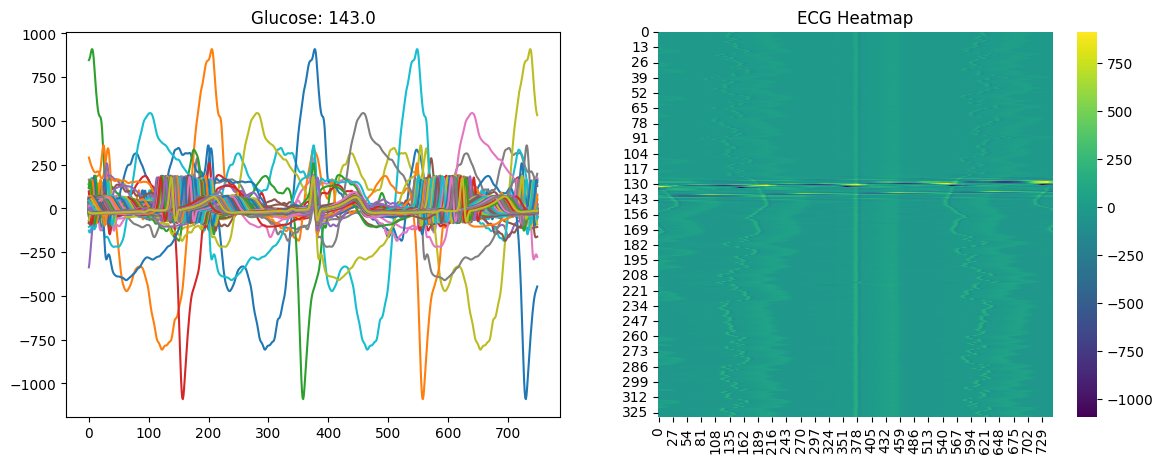

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
for i in range(clean_extracted_ecg.shape[0]):
    axs[0].plot(clean_extracted_ecg['ecg'][i])
axs[0].set_title(f'Glucose: {clean_extracted_ecg["glucose"][i]}')

heat_map = np.zeros((clean_extracted_ecg.shape[0], clean_extracted_ecg['ecg'][0].shape[0]))
for i in range(clean_extracted_ecg.shape[0]):
    heat_map[i, :] = clean_extracted_ecg['ecg'][i]

sns.heatmap(heat_map, ax=axs[1], cmap='viridis')
axs[1].set_title('ECG Heatmap')
plt.show()



## PPG Data

In [7]:
ppg_data = cgm_data['e4']['BVP']

In [8]:
ppg_fs = 64
ppg_clean = nk.ppg_clean(ppg_data['BVP'], sampling_rate=ppg_fs)

In [9]:
window_size = 30 * ppg_fs
overlap_ratio = 0.5

extracted_ppg = []
for i in tqdm.tqdm(range(0, ppg_data['Time'].shape[0], int(window_size * overlap_ratio))):
    try:
        start_idx = i
        end_idx = start_idx + window_size
        start_t = ppg_data['Time'][start_idx]
        end_t = ppg_data['Time'][end_idx]
        window_ppg = ppg_clean[start_idx:end_idx]

        extracted_ppg.append({
            'ppg': window_ppg,
            'start_t': start_t,
            'end_t': end_t,
            'glucose': cgm_glucose,
            'CGM_idx': cgm_idx,
            'Timestamp': cgm_timestamp,
        })
    except:
        pass

extracted_ppg = pd.DataFrame(extracted_ppg)

100%|██████████| 20/20 [00:00<00:00, 135957.99it/s]


In [10]:
print(extracted_ppg)

                                                  ppg  \
0   [1.3467850073399248, -2.201765172867073, -5.90...   
1   [4.490362954713383, 2.7180314596356716, 0.8804...   
2   [15.383047688078072, 13.899816423143943, 12.31...   
3   [-5.523025883873872, 3.164530648182616, 10.662...   
4   [13.485111850471865, 11.09107011811884, 9.1035...   
5   [24.447709806048792, 23.394738200792865, 22.35...   
6   [19.814470590079043, 21.12382774097026, 22.650...   
7   [-0.7905233361987882, 6.359869141966929, 12.29...   
8   [14.108253273137299, 13.473142745424013, 12.82...   
9   [19.998108665699338, 19.576468947918528, 17.95...   
10  [-1.6567417611203545, 5.5392082345223805, 11.4...   
11  [172.64275512388394, 149.38606650007097, 116.5...   
12  [36.28751434047841, 38.644309679634716, 38.791...   
13  [13.338140646353729, 17.85651128737274, 20.347...   
14  [4.808821834525993, 5.146234880264492, 5.30913...   
15  [-1.1616748271315451, -2.153754110530972, -3.3...   
16  [17.040988538389293, 15.724

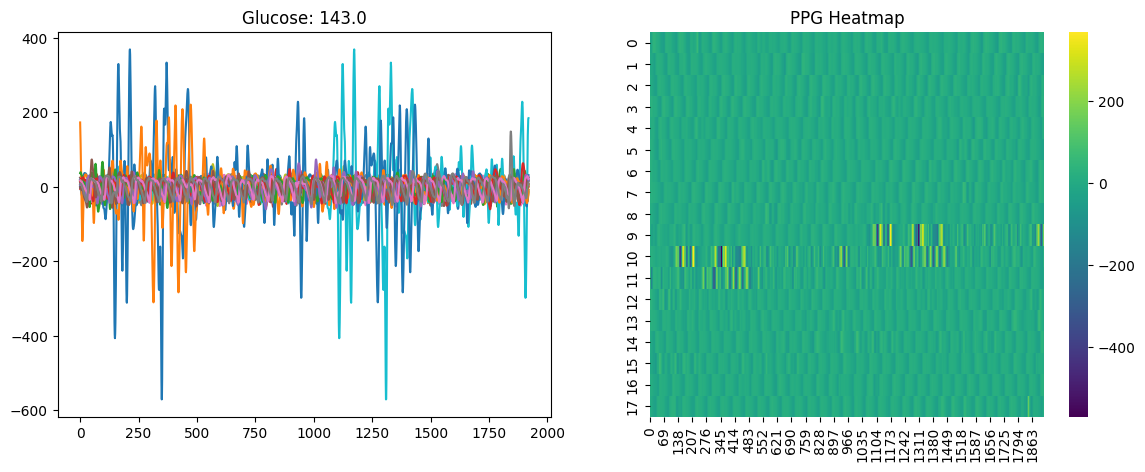

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
for i in range(extracted_ppg.shape[0]):
    axs[0].plot(extracted_ppg['ppg'][i])
axs[0].set_title(f'Glucose: {clean_extracted_ecg["glucose"][i]}')

heat_map = np.zeros((extracted_ppg.shape[0], extracted_ppg['ppg'][0].shape[0]))
for i in range(extracted_ppg.shape[0]):
    heat_map[i, :] = extracted_ppg['ppg'][i]

sns.heatmap(heat_map, ax=axs[1], cmap='viridis')
axs[1].set_title('PPG Heatmap')
plt.show()

## EDA

In [12]:
eda_data = cgm_data['e4']['EDA']
eda_sample_rate = 4
phasicdata = ledapy.runner.getResult(eda_data['EDA'], 'phasicdata', eda_sample_rate)
tonicdata = eda_data['EDA'] - phasicdata

extracted_eda = [{
    'phasic': phasicdata,
    'tonic': tonicdata,
    'start_t': eda_data['Time'][0],
    'end_t': eda_data['Time'][-1],
    'glucose': cgm_glucose,
    'CGM_idx': cgm_idx,
    'Timestamp': cgm_timestamp,
}]
extracted_eda = pd.DataFrame(extracted_eda)

print(extracted_eda)

                                              phasic  \
0  [0.038686472638035596, 0.04253147234832877, 0....   

                                               tonic                 start_t  \
0  [5.769101527361965, 5.769101527651671, 5.76910... 2022-06-13 03:29:06.250   

                end_t  glucose  CGM_idx           Timestamp  
0 2022-06-13 03:34:06    143.0  20426.0 2022-06-13 03:34:06  


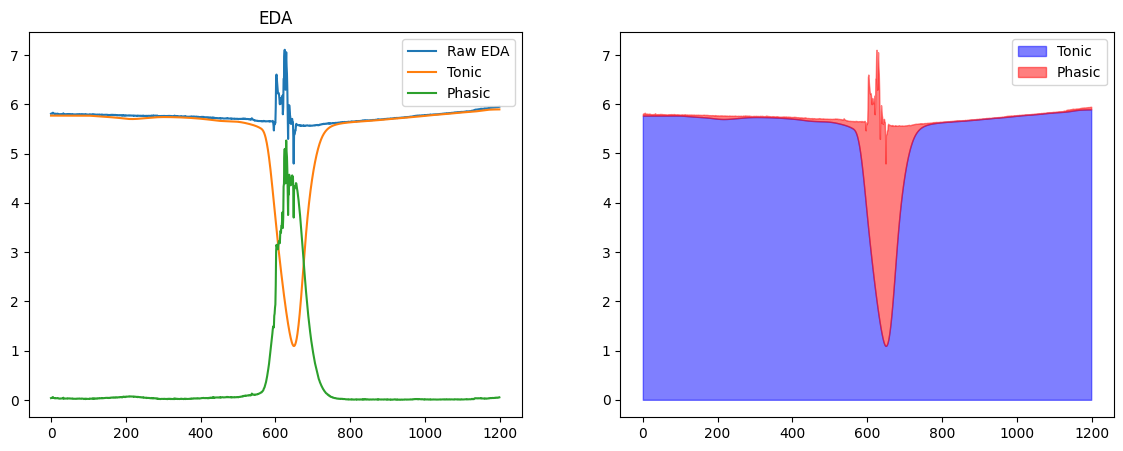

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
_extracted_data = extracted_eda.iloc[0]
raw_eda = _extracted_data['phasic'] + _extracted_data['tonic']
tonicdata = _extracted_data['tonic']
phasicdata = _extracted_data['phasic']

axs[0].plot(raw_eda, label='Raw EDA')
axs[0].plot(tonicdata, label='Tonic')
axs[0].plot(phasicdata, label='Phasic')
axs[0].legend()
axs[0].set_title('EDA')

axs[1].fill_between(np.arange(tonicdata.shape[0]), tonicdata, color='blue', alpha=0.5, label='Tonic')
axs[1].fill_between(np.arange(phasicdata.shape[0]), tonicdata, raw_eda, color='red', alpha=0.5, label='Phasic')
axs[1].legend()
plt.show()